In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "5"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [7]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [5]:
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

id_code  diagnosis            type
0  000c1434d8d7          2        Moderate
1  001639a390f0          4  Proliferate_DR
2  0024cdab0c1e          1            Mild
3  002c21358ce6          0           No_DR
4  005b95c28852          0           No_DR

<AxesSubplot:>

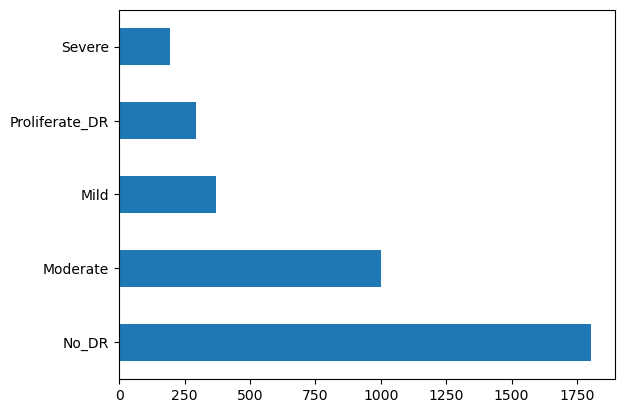

In [6]:
df['type'].value_counts().plot(kind='barh')

In [7]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [8]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [9]:
# Copy images to respective working directory
src_dir = 'gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [10]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [12]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
81/81 [==============================] - 53s 634ms/step - loss: 0.4010 - acc: 0.5937 - val_loss: 0.5353 - val_acc: 0.1727
Epoch 2/50
81/81 [==============================] - 32s 390ms/step - loss: 0.3086 - acc: 0.6780 - val_loss: 0.5265 - val_acc: 0.2727
Epoch 3/50
81/81 [==============================] - 34s 417ms/step - loss: 0.2873 - acc: 0.7022 - val_loss: 0.5230 - val_acc: 0.2945
Epoch 4/50
81/81 [==============================] - 32s 397ms/step - loss: 0.2768 - acc: 0.7041 - val_loss: 0.4864 - val_acc: 0.3655
Epoch 5/50
81/81 [==============================] - 33s 404ms/step - loss: 0.2661 - acc: 0.7221 - val_loss: 0.3817 - val_acc: 0.5891
Epoch 6/50
81/81 [==============================] - 32s 391ms/step - loss: 0.2607 - acc: 0.7147 - val_loss: 0.3160 - val_acc: 0.6855
Epoch 7/50
81/81 [==============================] - 30s 365ms/step - loss: 0.2537 - acc: 0.7330 - val_loss: 0.2776 - val_acc: 0.7145
Epoch 8/50
81/81 [==============================] - 34s 423ms/step - 

In [13]:
model.save('64x3-CNN(1).model')

INFO:tensorflow:Assets written to: 64x3-CNN(1).model\assets


INFO:tensorflow:Assets written to: 64x3-CNN(1).model\assets


In [14]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 8s 457ms/step - loss: 0.2454 - acc: 0.7509
Accuracy:  0.7509090900421143


In [15]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN(1).model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==2:
        print('No DR')
    elif per==0:
        print('Mild')
    elif per==1:
        print('Moderate')
    elif per==4:
        print('Severe')
    elif per==3:
        print('Proliferate_DR')
    else:
        print(per,'ERROR')

# No DR

1/1 [==============================] - 0s 279ms/step
No DR


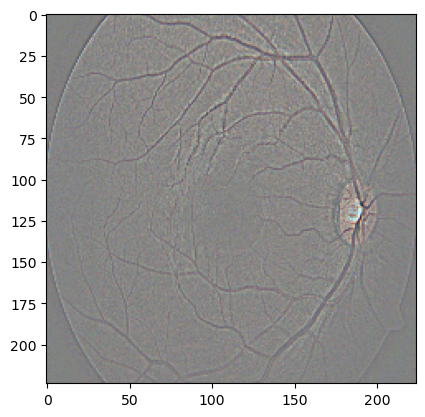

In [16]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/NO_DR/01f7bb8be950.png')

1/1 [==============================] - 0s 112ms/step
No DR


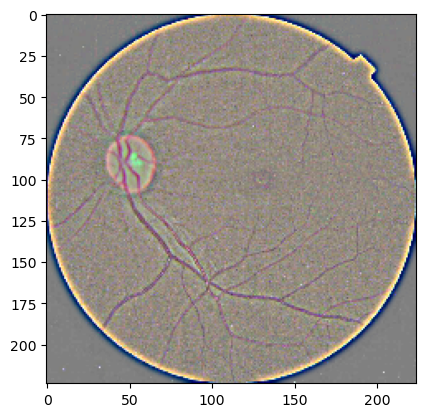

In [17]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/NO_DR/02da652c74b8.png')

1/1 [==============================] - 0s 136ms/step
No DR


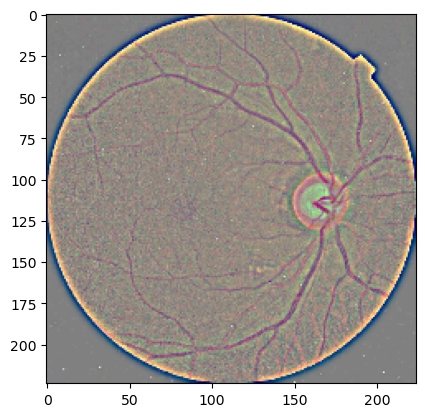

In [18]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/NO_DR/08bef347f40d.png')

1/1 [==============================] - 0s 280ms/step
No DR


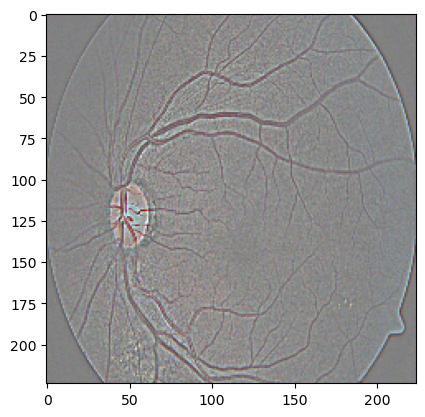

In [19]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/NO_DR/0a85a1e8f9e9.png')

# Mild

1/1 [==============================] - 0s 81ms/step
Moderate


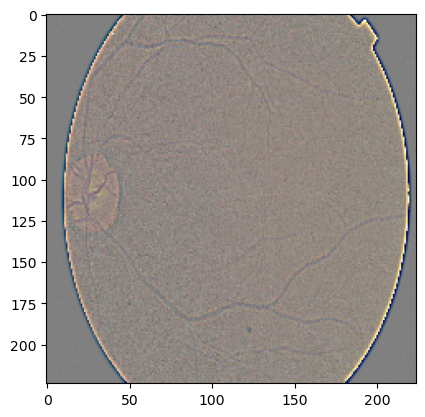

In [20]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png')

1/1 [==============================] - 0s 108ms/step
Mild


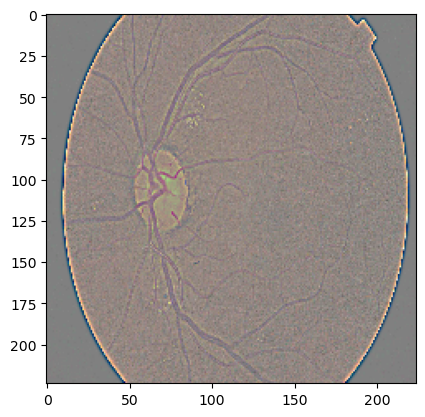

In [21]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Mild/05a5183c92d0.png')

1/1 [==============================] - 0s 201ms/step
Mild


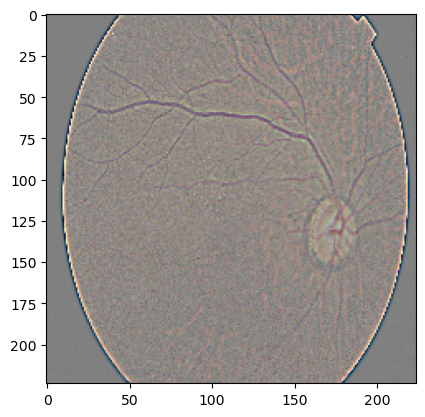

In [22]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Mild/0dce95217626.png')

1/1 [==============================] - 0s 108ms/step
Mild


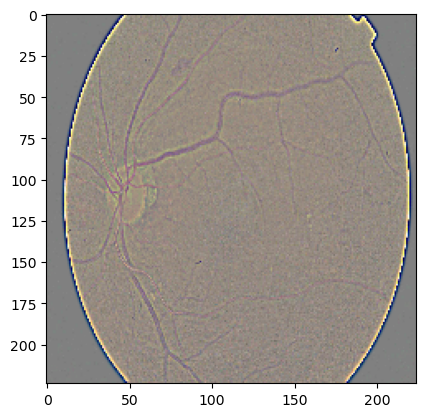

In [23]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Mild/2a08ed6bbcbc.png')

# Moderate

1/1 [==============================] - 0s 102ms/step
Proliferate_DR


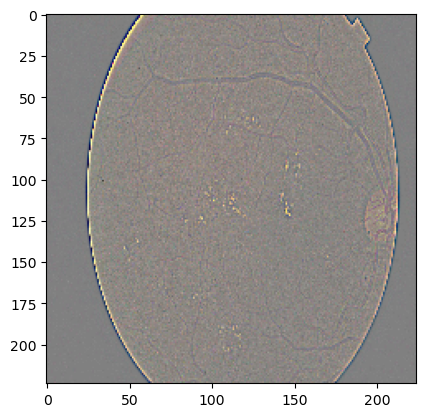

In [24]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png')

1/1 [==============================] - 0s 83ms/step
Mild


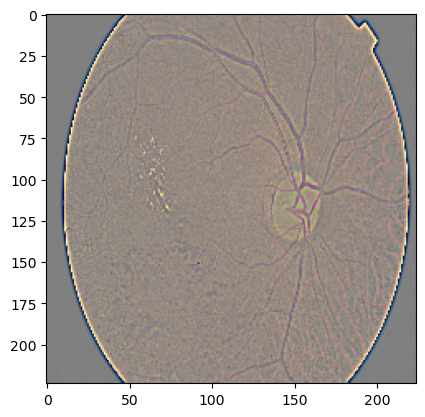

In [25]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/01eb826f6467.png')

1/1 [==============================] - 0s 94ms/step
Moderate


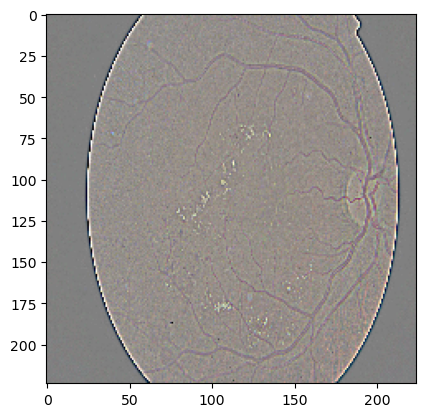

In [26]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/0da09e3ce8f1.png')

1/1 [==============================] - 0s 90ms/step
No DR


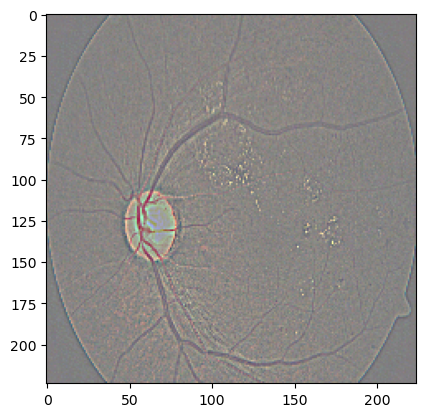

In [27]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/191348830ddf.png')

1/1 [==============================] - 0s 95ms/step
No DR


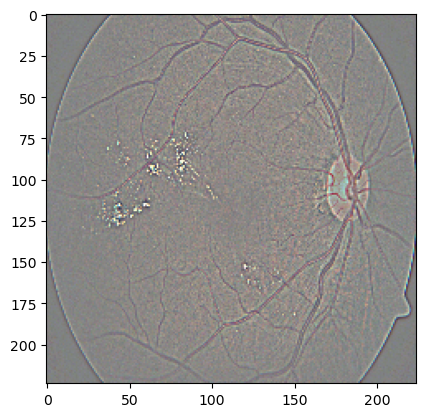

In [28]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/2376e5415458.png')

1/1 [==============================] - 0s 120ms/step
Moderate


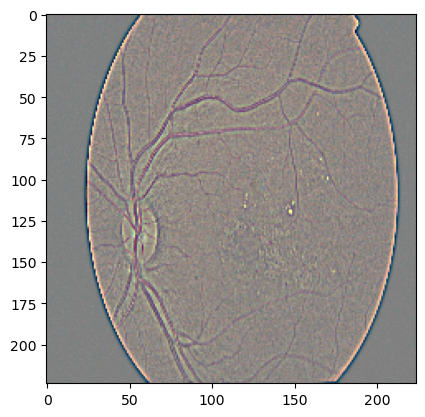

In [29]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Moderate/23d7ca170bdb.png')

# Severe

1/1 [==============================] - 0s 128ms/step
Severe


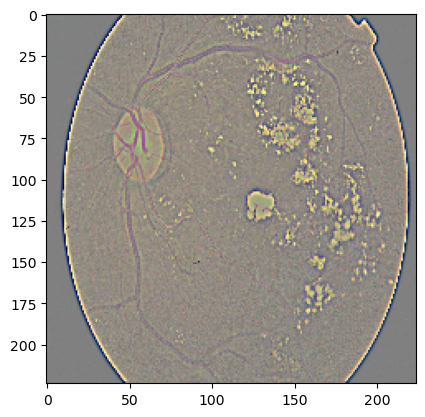

In [30]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Severe/0104b032c141.png')

1/1 [==============================] - 0s 96ms/step
Mild


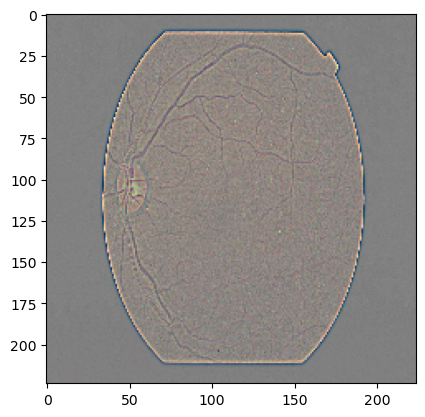

In [31]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Severe/36865bbc64d6.png')

1/1 [==============================] - 0s 84ms/step
Mild


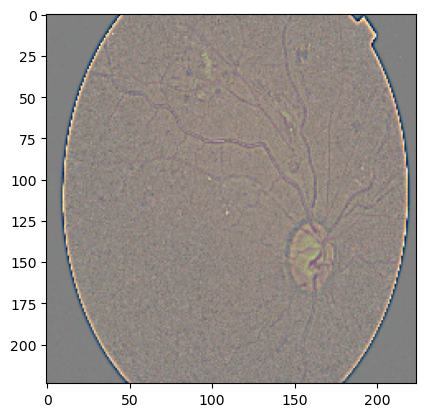

In [32]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Severe/3fa4f4d77177.png')

1/1 [==============================] - 0s 116ms/step
Severe


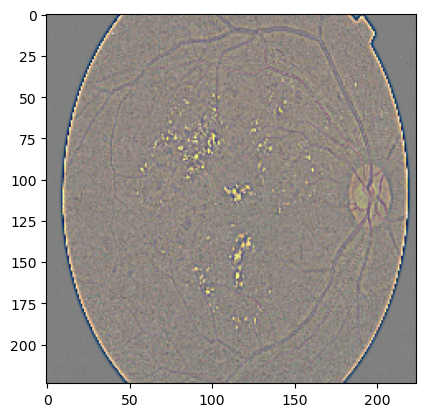

In [33]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Severe/4fecf87184e6.png')

1/1 [==============================] - 0s 83ms/step
Severe


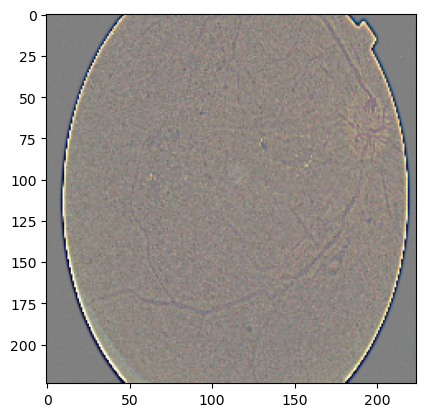

In [34]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Severe/762d6e5d5068.png')

# Proliferate_DR

1/1 [==============================] - 0s 98ms/step
Moderate


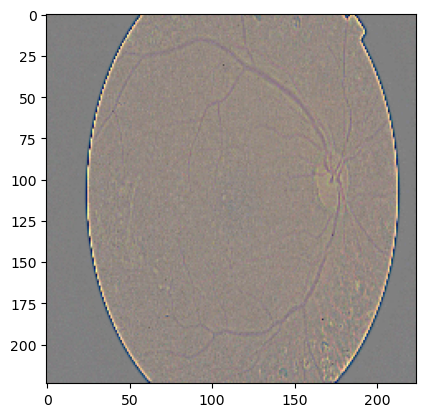

In [35]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/001639a390f0.png')

1/1 [==============================] - 0s 105ms/step
Proliferate_DR


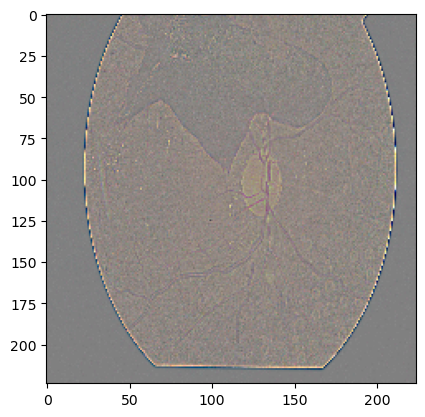

In [36]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/0e0fc1d9810c.png')

1/1 [==============================] - 0s 225ms/step
Proliferate_DR


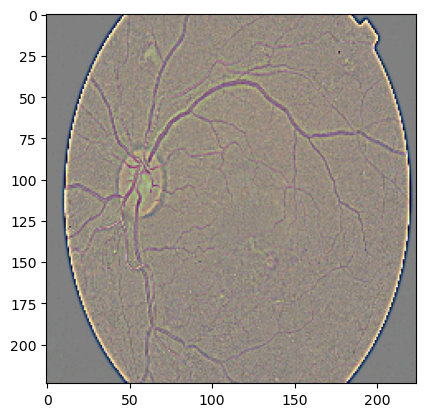

In [37]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/2628305cbb29.png')

1/1 [==============================] - 0s 96ms/step
Moderate


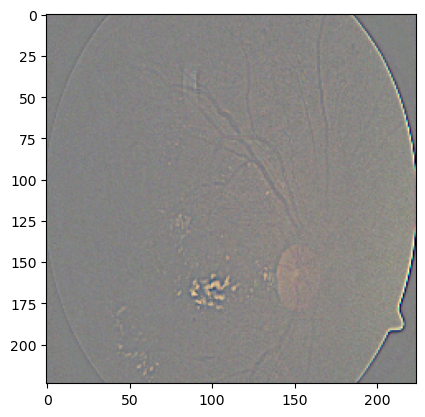

In [38]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/3a6e9730b298.png')

1/1 [==============================] - 0s 128ms/step
Moderate


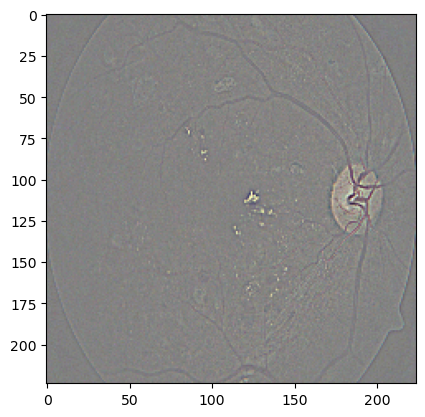

In [39]:
predict_class('gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/6f4719c6bb4b.png')

## Imbalanced Classification

### Data Augmentation

#### Image Data Generator (horizontal_flip)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
!pip install -q efficientnet

In [14]:
import efficientnet.tfkeras as efn

In [12]:
datagen = ImageDataGenerator(rotation_range=20,
                                      zoom_range=0.15,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.15,
                                      horizontal_flip=True,
                                      validation_split=0.2,
                                      fill_mode="nearest"
                                      )

train_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [15]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [16]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

In [17]:
history=model.fit_generator(train_data,validation_data=valid_data,callbacks=[lr_callback],epochs=25,verbose=1)

Epoch 1/25
92/92 [==============================] - 798s 8s/step - loss: 1.0223 - acc: 0.6527 - val_loss: 1.3019 - val_acc: 0.5595 - lr: 1.0000e-04
Epoch 2/25
92/92 [==============================] - 560s 6s/step - loss: 0.7803 - acc: 0.7168 - val_loss: 0.8488 - val_acc: 0.7114 - lr: 1.0000e-04
Epoch 3/25
92/92 [==============================] - 436s 5s/step - loss: 0.6518 - acc: 0.7612 - val_loss: 0.6760 - val_acc: 0.7620 - lr: 1.0000e-04
Epoch 4/25
92/92 [==============================] - 431s 5s/step - loss: 0.6010 - acc: 0.7779 - val_loss: 0.6340 - val_acc: 0.7579 - lr: 1.0000e-04
Epoch 5/25
92/92 [==============================] - 414s 5s/step - loss: 0.5817 - acc: 0.7786 - val_loss: 0.5745 - val_acc: 0.7798 - lr: 1.0000e-04
Epoch 6/25
92/92 [==============================] - 407s 4s/step - loss: 0.5499 - acc: 0.7820 - val_loss: 0.5794 - val_acc: 0.7893 - lr: 1.0000e-04
Epoch 7/25
92/92 [==============================] - 407s 4s/step - loss: 0.5020 - acc: 0.8072 - val_loss: 0.5590

In [18]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 15s 745ms/step - loss: 1.3704 - acc: 0.4927
Accuracy:  0.49272727966308594


#### Image Data Generator (Vertical flip)

In [19]:
datagen = ImageDataGenerator(rotation_range=20,
                                      zoom_range=0.15,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.15,
                                      vertical_flip=True,
                                      validation_split=0.2,
                                      fill_mode="nearest"
                                      )

train_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [20]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [21]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

In [22]:
history=model.fit_generator(train_data,validation_data=valid_data,callbacks=[lr_callback],epochs=25,verbose=1)

Epoch 1/25
92/92 [==============================] - 423s 4s/step - loss: 1.0573 - acc: 0.6418 - val_loss: 1.4683 - val_acc: 0.5267 - lr: 1.0000e-04
Epoch 2/25
92/92 [==============================] - 399s 4s/step - loss: 0.7609 - acc: 0.7202 - val_loss: 0.9485 - val_acc: 0.6895 - lr: 1.0000e-04
Epoch 3/25
92/92 [==============================] - 431s 5s/step - loss: 0.6738 - acc: 0.7557 - val_loss: 0.7327 - val_acc: 0.7346 - lr: 1.0000e-04
Epoch 4/25
92/92 [==============================] - 406s 4s/step - loss: 0.6481 - acc: 0.7700 - val_loss: 0.6176 - val_acc: 0.7784 - lr: 1.0000e-04
Epoch 5/25
92/92 [==============================] - 402s 4s/step - loss: 0.5833 - acc: 0.7871 - val_loss: 0.6148 - val_acc: 0.7620 - lr: 1.0000e-04
Epoch 6/25
92/92 [==============================] - 399s 4s/step - loss: 0.5665 - acc: 0.7847 - val_loss: 0.5961 - val_acc: 0.7647 - lr: 1.0000e-04
Epoch 7/25
92/92 [==============================] - 396s 4s/step - loss: 0.5293 - acc: 0.7963 - val_loss: 0.5694

In [23]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 13s 723ms/step - loss: 4.1639 - acc: 0.4927
Accuracy:  0.49272727966308594


#### Image Data Generator

In [12]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('gaussian_filtered_images/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [15]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [16]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

In [17]:
history=model.fit_generator(train_data,validation_data=valid_data,callbacks=[lr_callback],epochs=25,verbose=1)

Epoch 1/25
92/92 [==============================] - 694s 7s/step - loss: 1.0512 - acc: 0.6459 - val_loss: 1.0393 - val_acc: 0.6252 - lr: 1.0000e-04
Epoch 2/25
92/92 [==============================] - 655s 7s/step - loss: 0.7234 - acc: 0.7322 - val_loss: 0.9358 - val_acc: 0.6813 - lr: 1.0000e-04
Epoch 3/25
92/92 [==============================] - 651s 7s/step - loss: 0.6705 - acc: 0.7540 - val_loss: 0.7434 - val_acc: 0.7196 - lr: 1.0000e-04
Epoch 4/25
92/92 [==============================] - 651s 7s/step - loss: 0.5953 - acc: 0.7837 - val_loss: 0.6867 - val_acc: 0.7565 - lr: 1.0000e-04
Epoch 5/25
92/92 [==============================] - 661s 7s/step - loss: 0.5691 - acc: 0.7830 - val_loss: 0.6545 - val_acc: 0.7647 - lr: 1.0000e-04
Epoch 6/25
92/92 [==============================] - 669s 7s/step - loss: 0.5134 - acc: 0.8059 - val_loss: 0.5755 - val_acc: 0.7839 - lr: 1.0000e-04
Epoch 7/25
92/92 [==============================] - 661s 7s/step - loss: 0.4727 - acc: 0.8205 - val_loss: 0.6037

In [18]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 14s 767ms/step - loss: 0.2429 - acc: 0.9255
Accuracy:  0.9254545569419861


### Oversampling

<AxesSubplot:>

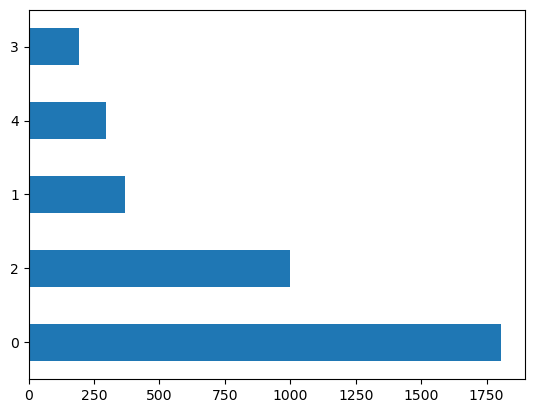

In [11]:
df['diagnosis'].value_counts().plot(kind='barh')

In [12]:
df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
 2   type       3662 non-null   object
dtypes: int64(1), object(2)
memory usage: 86.0+ KB


In [14]:
from sklearn.utils import resample

df_majority =df[(df['diagnosis']==0)] 
df_minority_1 = df[(df['diagnosis']==1)] 
df_minority_2 = df[(df['diagnosis']==2)]
df_minority_3 = df[(df['diagnosis']==3)]
df_minority_4 = df[(df['diagnosis']==4)] 

# upsample minority class
df_minority_upsampled1 = resample(df_minority_1, 
                                 replace=True,   
                                 n_samples= 1805, 
                                 random_state=42) 

df_minority_upsampled2 = resample(df_minority_2, 
                                 replace=True,   
                                 n_samples= 1805, 
                                 random_state=42) 

df_minority_upsampled3 = resample(df_minority_3, 
                                 replace=True,   
                                 n_samples= 1805, 
                                 random_state=42)

df_minority_upsampled4 = resample(df_minority_4, 
                                 replace=True,   
                                 n_samples= 1805, 
                                 random_state=42) 

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled1, df_majority])
df_upsampled = pd.concat([df_minority_upsampled2, df_upsampled])
df_upsampled = pd.concat([df_minority_upsampled3, df_upsampled])
df_upsampled = pd.concat([df_minority_upsampled4, df_upsampled])

In [15]:
df_upsampled['diagnosis'].value_counts()

4    1805
3    1805
2    1805
1    1805
0    1805
Name: diagnosis, dtype: int64

In [16]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9025 entries, 1350 to 3660
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    9025 non-null   object
 1   diagnosis  9025 non-null   int64 
 2   type       9025 non-null   object
dtypes: int64(1), object(2)
memory usage: 282.0+ KB


In [52]:
df_upsampled.head(-5)

id_code  diagnosis            type
1350  5dd2e26fc244          4  Proliferate_DR
3394  eb1d37b71fd1          4  Proliferate_DR
1385  613028ede6a0          4  Proliferate_DR
843   3ca637fddd56          4  Proliferate_DR
2304  a182b5b191de          4  Proliferate_DR
...            ...        ...             ...
3644  fefded6bf135          0           No_DR
3645  ff03f74667df          0           No_DR
3647  ff1e940105f9          0           No_DR
3649  ff4832d55461          0           No_DR
3650  ff4955e76894          0           No_DR

[9020 rows x 3 columns]

In [54]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df_upsampled, test_size = 0.15, stratify = df_upsampled['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

Moderate          1264
No_DR             1264
Proliferate_DR    1263
Mild              1263
Severe            1263
Name: type, dtype: int64 

Severe            271
Proliferate_DR    271
No_DR             271
Mild              271
Moderate          270
Name: type, dtype: int64 

Mild              271
Severe            271
Proliferate_DR    271
Moderate          271
No_DR             270
Name: type, dtype: int64 



In [55]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [56]:
# Copy images to respective working directory
src_dir = 'gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [57]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2796 images belonging to 5 classes.
Found 1012 images belonging to 5 classes.
Found 1018 images belonging to 5 classes.


In [58]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
88/88 [==============================] - 102s 1s/step - loss: 0.5403 - acc: 0.5018 - val_loss: 0.5663 - val_acc: 0.2302
Epoch 2/50
88/88 [==============================] - 73s 823ms/step - loss: 0.3684 - acc: 0.6012 - val_loss: 0.5448 - val_acc: 0.2302
Epoch 3/50
88/88 [==============================] - 69s 783ms/step - loss: 0.3376 - acc: 0.6323 - val_loss: 0.5204 - val_acc: 0.2381
Epoch 4/50
88/88 [==============================] - 67s 765ms/step - loss: 0.3205 - acc: 0.6456 - val_loss: 0.4603 - val_acc: 0.3103
Epoch 5/50
88/88 [==============================] - 64s 729ms/step - loss: 0.3063 - acc: 0.6652 - val_loss: 0.3990 - val_acc: 0.5138
Epoch 6/50
88/88 [==============================] - 64s 732ms/step - loss: 0.3063 - acc: 0.6634 - val_loss: 0.3613 - val_acc: 0.5642
Epoch 7/50
88/88 [==============================] - 64s 731ms/step - loss: 0.2945 - acc: 0.6745 - val_loss: 0.3509 - val_acc: 0.5692
Epoch 8/50
88/88 [==============================] - 59s 671ms/step - lo

In [59]:
model.save('64x3-CNN(2).model')

INFO:tensorflow:Assets written to: 64x3-CNN(2).model\assets


INFO:tensorflow:Assets written to: 64x3-CNN(2).model\assets


In [60]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

32/32 [==============================] - 9s 291ms/step - loss: 0.1977 - acc: 0.8487
Accuracy:  0.8487229943275452


### Undersampling

In [17]:
df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [18]:
df_minority_unsampled1 = resample(df_minority_1, 
                                 replace=True,   
                                 n_samples= 193, 
                                 random_state=42) 

df_minority_unsampled2 = resample(df_minority_2, 
                                 replace=True,   
                                 n_samples= 193, 
                                 random_state=42) 

df_minority_unsampled3 = resample(df_minority_3, 
                                 replace=True,   
                                 n_samples= 193, 
                                 random_state=42)

df_minority_unsampled4 = resample(df_minority_4, 
                                 replace=True,   
                                 n_samples= 193, 
                                 random_state=42) 
df_majority= resample(df_majority, 
                      replace=True,   
                      n_samples= 193, 
                      random_state=42) 

# Combine majority class with upsampled minority class
df_unsampled = pd.concat([df_minority_unsampled1, df_majority])
df_unsampled = pd.concat([df_minority_unsampled2, df_unsampled])
df_unsampled = pd.concat([df_minority_unsampled3, df_unsampled])
df_unsampled = pd.concat([df_minority_unsampled4, df_unsampled])

In [19]:
df_unsampled['diagnosis'].value_counts()

4    193
3    193
2    193
1    193
0    193
Name: diagnosis, dtype: int64

In [20]:
df_unsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 1350 to 2476
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    965 non-null    object
 1   diagnosis  965 non-null    int64 
 2   type       965 non-null    object
dtypes: int64(1), object(2)
memory usage: 30.2+ KB


In [66]:
df_unsampled.head(-5)

id_code  diagnosis            type
1350  5dd2e26fc244          4  Proliferate_DR
3394  eb1d37b71fd1          4  Proliferate_DR
1385  613028ede6a0          4  Proliferate_DR
843   3ca637fddd56          4  Proliferate_DR
2304  a182b5b191de          4  Proliferate_DR
...            ...        ...             ...
1214  54038e56131d          0           No_DR
2132  96793edb1003          0           No_DR
194   0e43c8298fc0          0           No_DR
3573  f90f8931a9bc          0           No_DR
1046  4aa3d771c5e4          0           No_DR

[960 rows x 3 columns]

In [67]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df_unsampled, test_size = 0.15, stratify = df_unsampled['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             135
Mild              135
Moderate          135
Proliferate_DR    135
Severe            135
Name: type, dtype: int64 

No_DR             29
Severe            29
Moderate          29
Mild              29
Proliferate_DR    29
Name: type, dtype: int64 

Proliferate_DR    29
Severe            29
Moderate          29
No_DR             29
Mild              29
Name: type, dtype: int64 



In [68]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [69]:
# Copy images to respective working directory
src_dir = 'gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['diagnosis']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [70]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 574 images belonging to 5 classes.
Found 137 images belonging to 5 classes.
Found 139 images belonging to 5 classes.


In [71]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

Epoch 1/50
18/18 [==============================] - 23s 1s/step - loss: 0.7764 - acc: 0.2404 - val_loss: 0.6725 - val_acc: 0.1752
Epoch 2/50
18/18 [==============================] - 15s 835ms/step - loss: 0.5840 - acc: 0.3746 - val_loss: 0.6434 - val_acc: 0.1971
Epoch 3/50
18/18 [==============================] - 14s 793ms/step - loss: 0.5135 - acc: 0.4042 - val_loss: 0.6240 - val_acc: 0.1971
Epoch 4/50
18/18 [==============================] - 14s 796ms/step - loss: 0.4746 - acc: 0.4739 - val_loss: 0.6078 - val_acc: 0.1971
Epoch 5/50
18/18 [==============================] - 16s 882ms/step - loss: 0.4560 - acc: 0.4913 - val_loss: 0.5925 - val_acc: 0.1971
Epoch 6/50
18/18 [==============================] - 16s 890ms/step - loss: 0.4361 - acc: 0.5052 - val_loss: 0.5802 - val_acc: 0.1971
Epoch 7/50
18/18 [==============================] - 14s 784ms/step - loss: 0.4179 - acc: 0.5122 - val_loss: 0.5651 - val_acc: 0.1971
Epoch 8/50
18/18 [==============================] - 15s 822ms/step - los

In [72]:
model.save('64x3-CNN(3).model')

INFO:tensorflow:Assets written to: 64x3-CNN(3).model\assets


INFO:tensorflow:Assets written to: 64x3-CNN(3).model\assets


In [73]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

5/5 [==============================] - 2s 474ms/step - loss: 0.3437 - acc: 0.6547
Accuracy:  0.6546762585639954


In [11]:
l=[0.7509090900421143,0.49272727966308594,0.49272727966308594,0.9254545569419861,0.8487229943275452,0.6546762585639954]

In [16]:
title=["IDG","IDGhf","IDGvf","IDGf","Oversampling","Undersampling"]

In [13]:
for i in range (0,6):
    l[i]=l[i]*100

In [14]:
l

[75.09090900421143,
 49.272727966308594,
 49.272727966308594,
 92.54545569419861,
 84.87229943275452,
 65.46762585639954]

Text(0.5, 1.0, 'COMPARATIVE ANALYSIS')

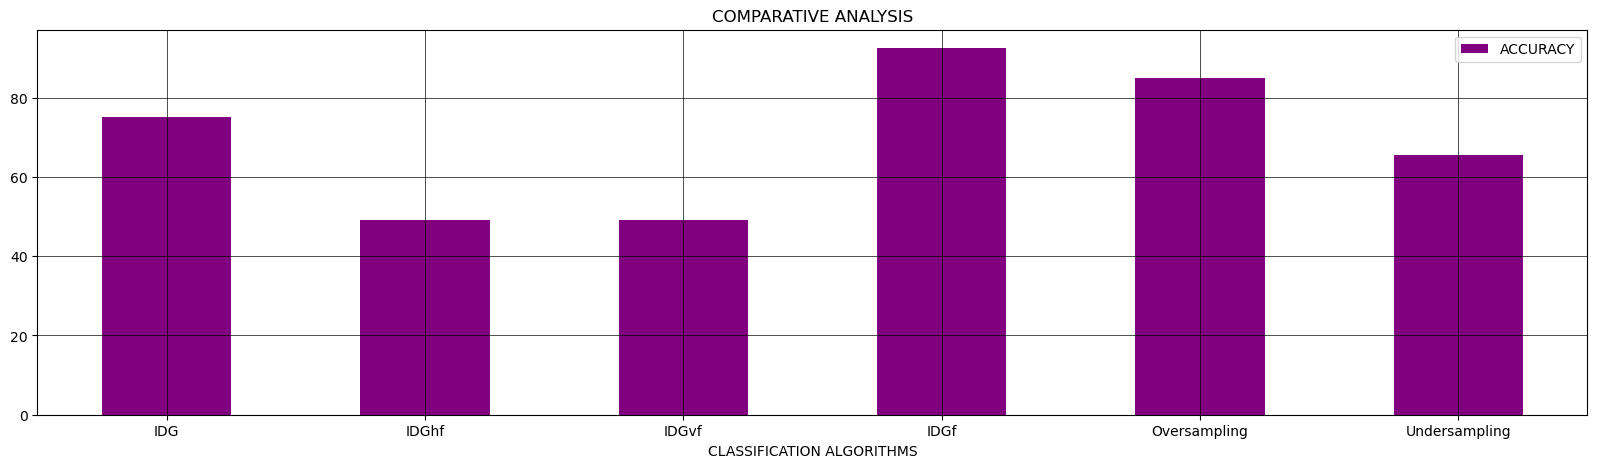

In [17]:
df=pd.DataFrame({'CLASSIFICATION ALGORITHMS':title, 'ACCURACY':l})
ax=df.plot.bar(x='CLASSIFICATION ALGORITHMS', y='ACCURACY',rot=0,figsize=(20,5),
              color='purple')
plt.grid(color='black', linewidth=0.7, axis='both', alpha=0.7)
plt.title('COMPARATIVE ANALYSIS')